In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.functional as f 
from torch.autograd import Variable
torch.backends.cudnn.deterministic = True
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random 
from matplotlib import pyplot as plt

from sklearn import decomposition

from sklearn import manifold
from scipy import stats


import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [4]:
number = 1

fileTrain = '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Train_rrlyr-'+str(number)+'.csv'
fileTest = '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Test_rrlyr-'+str(number)+'.csv'
train_dataset = pd.read_csv(fileTrain, index_col ='Unnamed: 0')
test_dataset = pd.read_csv(fileTest)

In [5]:
train_dataset[['survey', 'zone', 'class', 'id-']]= train_dataset['ID'].str.split("-",expand=True)
test_dataset[['survey', 'zone', 'class', 'id-']]= test_dataset['ID'].str.split("-",expand=True)

In [6]:
try:
    train_dataset =  train_dataset.drop(['Pred', 'Pred2', 'h', 'e', 'u','ID','survey', 'zone','id-', 'label'], axis = 1)
    for col in train_dataset.columns:
        if col not in ['class']:
            if train_dataset[col].var()==0:
                print(col)
                del train_dataset[col]
    test_dataset = test_dataset[list(train_dataset.columns)]
except:
    print(col)
    print('---')

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0


In [7]:
n = train_dataset.shape[0] 
epsilon = 0
input_size = train_dataset.shape[1]-1
hidden_size = 50
hidden_size2 = 50
num_classes = 12
num_epochs = 5
batch_size = 128
learning_rate = 0.001
regularization = False
add_DR_based_data = True


In [8]:
train_dataset = train_dataset.sample(n)
train_dataset.head()


,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,FluxPercentileRatioMid20,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,class
391262,0.15100,0.001250,10,0.346667,22.791959,0.537868,0.619429,0.02349,14.104876,0.145522,...,0.194838,17.79498,-0.488208,0.078843,0.814231,0.784707,1.801910,2.535099,1.448028,LPV
230291,0.01750,0.115532,2,0.363333,274.744191,0.211135,0.053812,0.00000,5.686240,0.166667,...,0.133719,5.69361,0.111186,0.009347,0.793480,0.745731,1.620815,2.129265,1.607298,LPV
26148,0.02575,0.536316,2,0.299065,39.534998,0.553698,0.389701,0.00000,6307.485427,0.186047,...,-0.058798,4.92600,-0.091798,0.012686,0.791180,0.738202,1.453116,1.593353,1.206530,LPV
34003,0.01825,0.253883,5,0.283186,206.752429,0.049652,0.068576,0.00000,8.364235,0.156250,...,-0.502323,1.18029,1.457469,0.010113,0.777735,0.741196,1.317766,1.621916,1.385394,LPV
189282,0.45500,0.000000,1,0.220000,18.179650,0.189635,1.087083,0.00000,17.117858,0.088483,...,1.129390,1.89933,2.278362,0.219409,0.742077,0.726959,2.211178,3.532070,1.632040,ECL


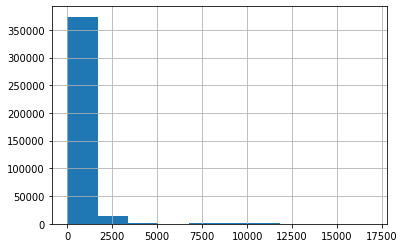

In [11]:
train_dataset['PeriodLS'].hist()
plt.show()

In [12]:
label = train_dataset['class']
del train_dataset['class']
train_dataset_z=(train_dataset-train_dataset.mean())/train_dataset.std()
z_scores = stats.zscore(train_dataset_z)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
train_dataset['class'] = label
train_dataset = train_dataset[filtered_entries]

In [13]:
train_dataset['class'].unique()

array(['LPV', 'ECL', 'RRLYR', 'CEP', 'DSCT', 'DPV', 'T2CEP', 'RCB',
       'ACEP', 'ACV'], dtype=object)

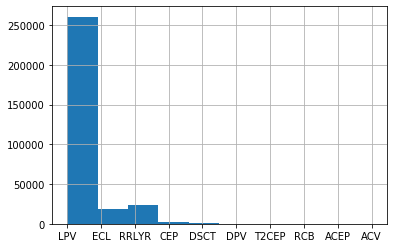

In [14]:
train_dataset['class'].hist()

In [15]:
for i in ['T2CEP', 'RCB','ACEP', 'ACV','DN']: 
    train_dataset=train_dataset[train_dataset['class']!=i]
    test_dataset=test_dataset[test_dataset['class']!=i]

In [16]:
train_dataset['class'].unique()

array(['LPV', 'ECL', 'RRLYR', 'CEP', 'DSCT', 'DPV'], dtype=object)

In [17]:
label = test_dataset['class']
del test_dataset['class']
test_dataset_z=(test_dataset-test_dataset.mean())/test_dataset.std()
z_scores = stats.zscore(test_dataset_z)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
test_dataset['class'] = label
test_dataset = test_dataset[filtered_entries]

In [62]:
train_dataset.shape

(276882, 61)

In [19]:
samples = 1000
number_columns = train_dataset.shape[1]
if add_DR_based_data:
    for i in range(samples):
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']= (np.random.uniform(0.2-epsilon,1.0+epsilon))
        new_data['class'] = 'rrlyrae-U'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2 = [test_dataset, new_data]
        test_dataset = pd.concat(frames2)
    
    for i in range(0):
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']=(np.random.uniform(0.0,0.2))
        new_data['class'] = 'non-rrlyrae-U'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2 = [test_dataset, new_data]
        test_dataset = pd.concat(frames2)
        
    for i in range(0):    
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']=(np.random.uniform(1.0,1.2))
        new_data['class'] = 'non-rrlyrae-U'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2 = [test_dataset, new_data]
        test_dataset = pd.concat(frames2)
        
    for i in range(0):    
        new_data = pd.DataFrame([train_dataset.sample(1000).mean()]).T
        new_data['PeriodLS']= 1.0
        new_data['class'] = 'threashold-1'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2 = [test_dataset, new_data]
        test_dataset = pd.concat(frames2)
        
       
    for i in range(0):    
        new_data = pd.DataFrame([train_dataset.sample(1000).mean()]).T
        new_data.columns = train_dataset.columns
        new_data['PeriodLS']= 0.2
        new_data['class'] = 'threashold-2'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2 = [test_dataset, new_data]
        test_dataset = pd.concat(frames2)

In [20]:
train_dataset['class'].unique()

array(['LPV', 'ECL', 'RRLYR', 'CEP', 'DSCT', 'DPV', 'rrlyrae-U'],
      dtype=object)

In [21]:
test_dataset['class'].unique()

array(['ECL', 'RRLYR', 'CEP', 'LPV', 'DSCT', 'DPV', 'rrlyrae-U'],
      dtype=object)

In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train_dataset['label']=le.fit_transform(train_dataset['class'])
test_dataset['label']=le.transform(test_dataset['class']) 
del train_dataset['class']
del test_dataset['class']

In [23]:
train_dataset['label'].unique()

array([4, 3, 5, 0, 2, 1, 6])

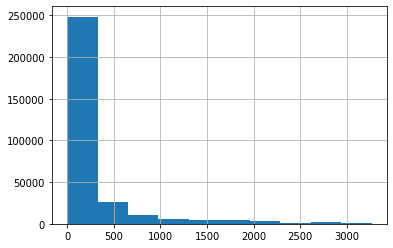

In [24]:
train_dataset['PeriodLS'].hist()
plt.show()

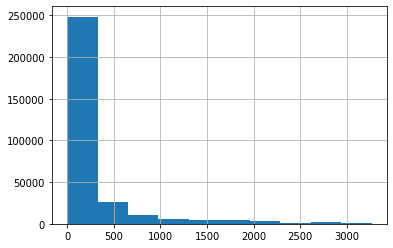

In [25]:
train_dataset['PeriodLS'].hist()
plt.show()

In [26]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

Cases using DR 1: Period $ \in [0.2,1.0]$ days

In [27]:
train_target = torch.from_numpy(np.asarray(train_dataset['label'])).long()
train_target = torch.tensor(train_dataset['label'].values.astype(np.float32))
train = torch.tensor(train_dataset.drop('label', axis = 1).values.astype(np.float32)) 
train = f.normalize(train)
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size)

In [28]:
val_target = torch.from_numpy(np.asarray(val_dataset['label'])).long()
#val_dataset['label'] = val_dataset['label'].astype(float) 
val_target = torch.tensor(val_dataset['label'].values.astype(np.float32))
val = torch.tensor(val_dataset.drop('label', axis = 1).values.astype(np.float32)) 
val = f.normalize(val)
val_tensor = data_utils.TensorDataset(val, val_target) 
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = batch_size)

In [29]:
test_target = torch.from_numpy(np.asarray(test_dataset['label'])).long()
test = torch.tensor(test_dataset.drop('label', axis = 1).values.astype(np.float32)) 

test = f.normalize(test)
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size)

In [30]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, hidden_size)
        self.hidden_fc = nn.Linear(hidden_size, hidden_size2)
        self.output_fc = nn.Linear(hidden_size2, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        #x = [batch size, height * width]
        
        h_1 = f.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = f.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        
        #y_pred = [batch size, output dim]
        
        return y_pred, h_2, h_1
    
model = Net(input_size, num_classes)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,212 trainable parameters


In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [33]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
model = model.to(device)
criterion = criterion.to(device)

In [36]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [37]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _, _ = model(x)
        
        loss = criterion(y_pred, y.long())
        
        acc = calculate_accuracy(y_pred, y.long())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [38]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _, _ = model(x)

            loss = criterion(y_pred, y.long())

            acc = calculate_accuracy(y_pred, y.long())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.316 | Train Acc: 91.17%
	 Val. Loss: 0.139 |  Val. Acc: 96.40%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.119 | Train Acc: 96.70%
	 Val. Loss: 0.104 |  Val. Acc: 97.17%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.092 | Train Acc: 97.42%
	 Val. Loss: 0.082 |  Val. Acc: 97.90%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.075 | Train Acc: 97.95%
	 Val. Loss: 0.069 |  Val. Acc: 98.20%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.064 | Train Acc: 98.20%
	 Val. Loss: 0.060 |  Val. Acc: 98.36%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.057 | Train Acc: 98.45%
	 Val. Loss: 0.053 |  Val. Acc: 98.71%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.051 | Train Acc: 98.67%
	 Val. Loss: 0.048 |  Val. Acc: 98.86%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.047 | Train Acc: 98.80%
	 Val. Loss: 0.045 |  Val. Acc: 98.92%
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.044 | Train Acc: 98.89%
	 Val. Loss: 0.041 |  Val. Acc: 99.00%
Epoch: 10 | Epoch Time: 0m 5

In [41]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

In [42]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.484 | Test Acc: 85.46%


In [43]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize = (20, 10))
    
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(5, 10).cpu().numpy(), cmap = 'bone')
        #plt.title(str(train_target[i]))
        ax.axis('off')

In [44]:
def get_representations(model, iterator, device):

    model.eval()
    outputs = []
    intermediates = []
    intermediates2 = []
    labels = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, h2, h1 = model(x)
            outputs.append(y_pred.cpu())
            intermediates.append(h1.cpu())
            intermediates2.append(h2.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    intermediates2 = torch.cat(intermediates2, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, intermediates2, labels

In [45]:
outputs, intermediates, intermediates2, labels = get_representations(model, train_loader, device)

outputs_test, intermediates_test, intermediates2_test, labels_test = get_representations(model, test_loader, device)

In [47]:
def plot_representations(data, labels, n_curves = None):
    if n_curves is not None:
        data = data[:n_curves]
        labels = labels[:n_curves]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1],c=labels, alpha =0.5)
    handles, labels = scatter.legend_elements()
    labels = list(le.classes_)
    plt.legend(handles=scatter.legend_elements()[0], labels=labels)
    #legend = ax.legend(handles = handles, labels = labels)

In [48]:
def get_pca(data, data_test=None, n_components = 2):
    pca = decomposition.PCA()
    
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    
    if data_test is not None: 
        pca_data_test = pca.transform(data_test)
        return tsne_data, pca_data_test 
    
    return pca_data


def get_tsne(data, data_test = None, n_components = 2, n_curves = None):
    if n_curves is not None:
        data = data[:n_curves]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    
    if data_test is not None: 
        tsne_data_test = tsne.transform(data_test)
        return tsne_data, tsne_data_test  
    
    return tsne_data

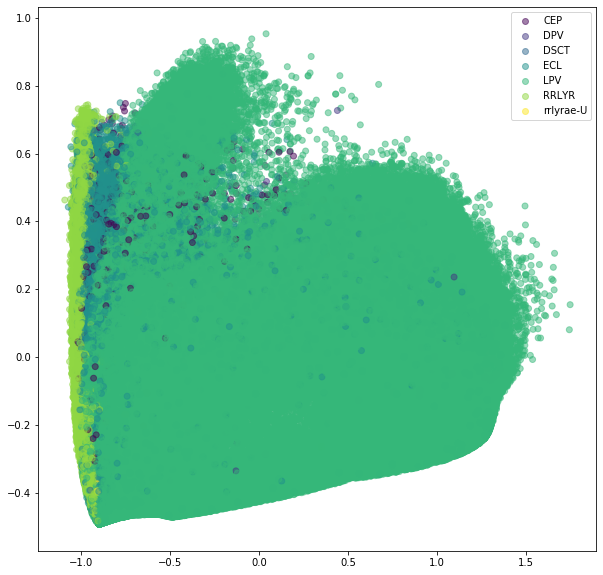

In [49]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

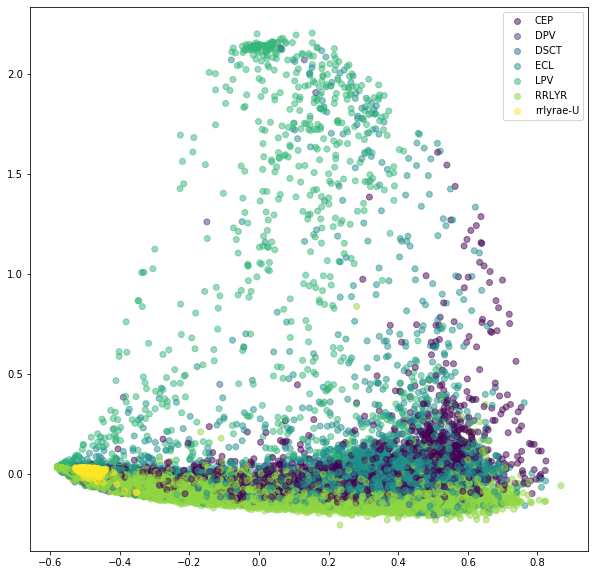

In [58]:
intermediate_pca_data_test = get_pca(intermediates_test)
plot_representations(intermediate_pca_data_test, labels_test)

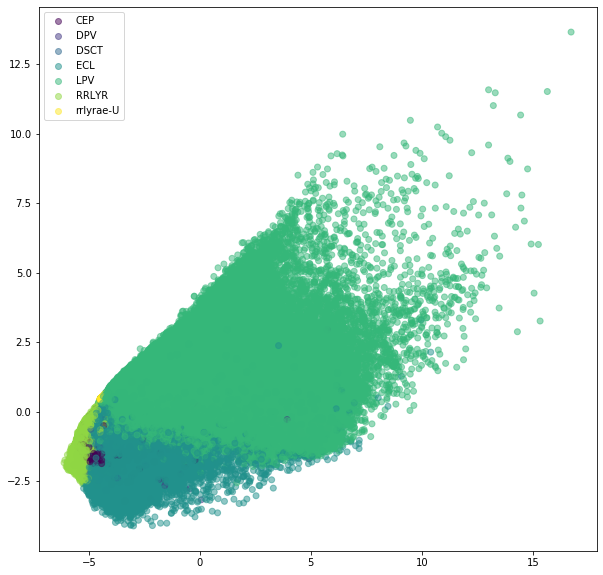

In [50]:
intermediate2_pca_data = get_pca(intermediates2)
plot_representations(intermediate2_pca_data, labels)

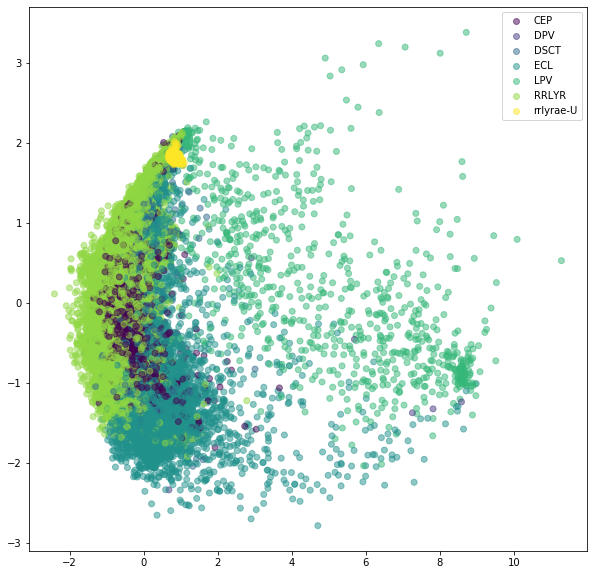

In [60]:
intermediate2_pca_data_test = get_pca(intermediates2_test)
plot_representations(intermediate2_pca_data_test, labels_test)

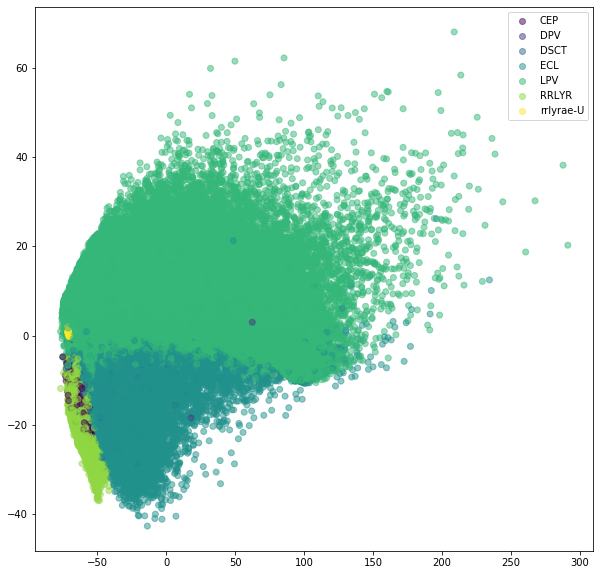

In [51]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

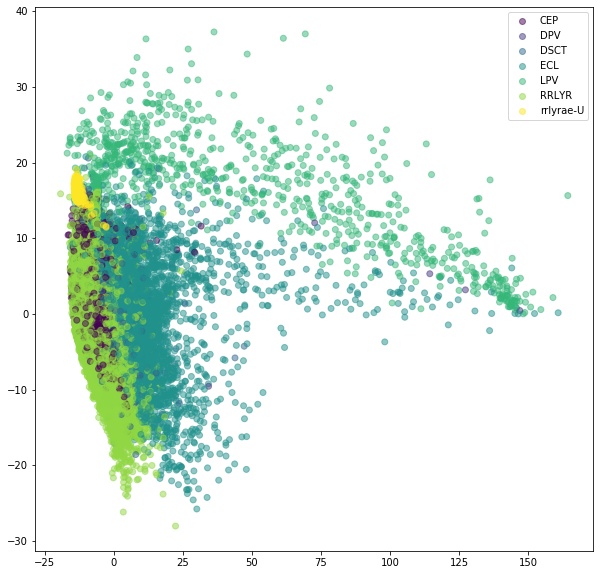

In [61]:
output_pca_data_test = get_pca(outputs_test)
plot_representations(output_pca_data_test, labels_test)

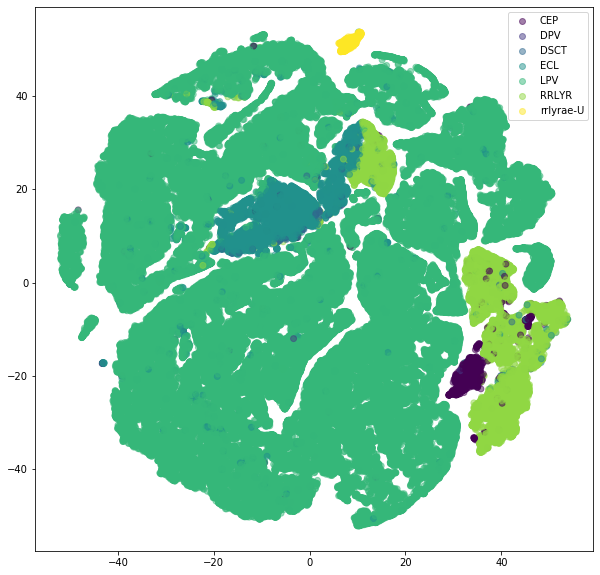

In [52]:
N_CURVES = 100000
intermediate_tsne_data = get_tsne(intermediates, n_curves = N_CURVES)
plot_representations(intermediate_tsne_data, labels, n_curves = N_CURVES)

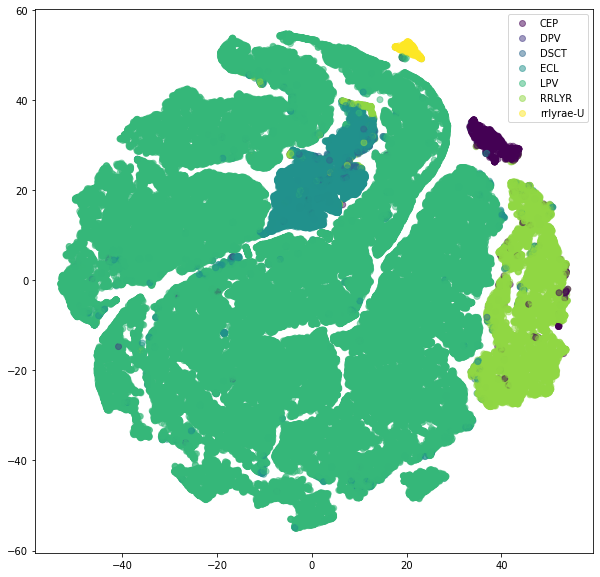

In [53]:
intermediate2_tsne_data = get_tsne(intermediates2, n_curves = N_CURVES)
plot_representations(intermediate2_tsne_data, labels, n_curves = N_CURVES)

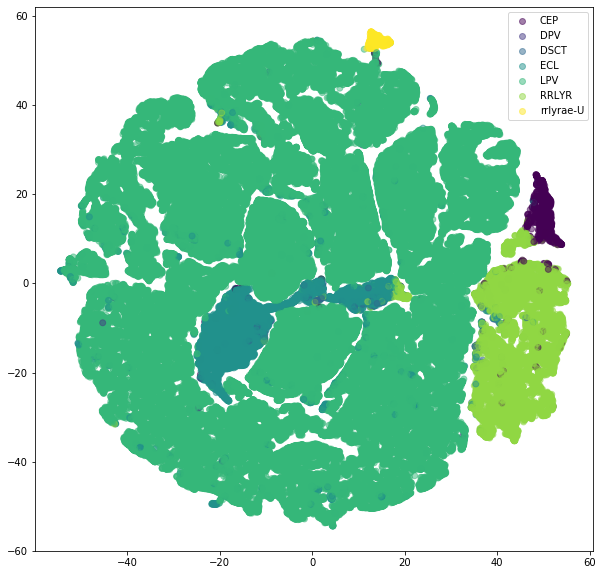

In [54]:
output_tsne_data = get_tsne(outputs, n_curves = N_CURVES)
plot_representations(output_tsne_data, labels, n_curves = N_CURVES)

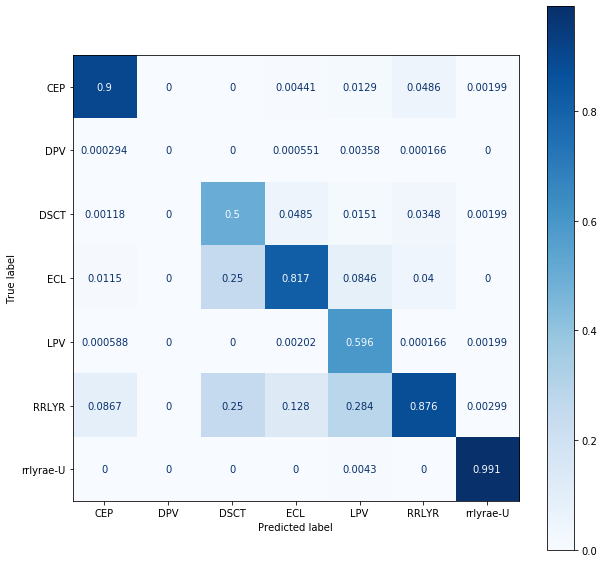

In [55]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels, normalize='pred');
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = list(le.classes_));
    cm.plot(values_format ='.3g', cmap = 'Blues', ax = ax)
    #plt.show()
    
    
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []
    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _, _ = model(x)

            y_prob = f.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs


images, labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

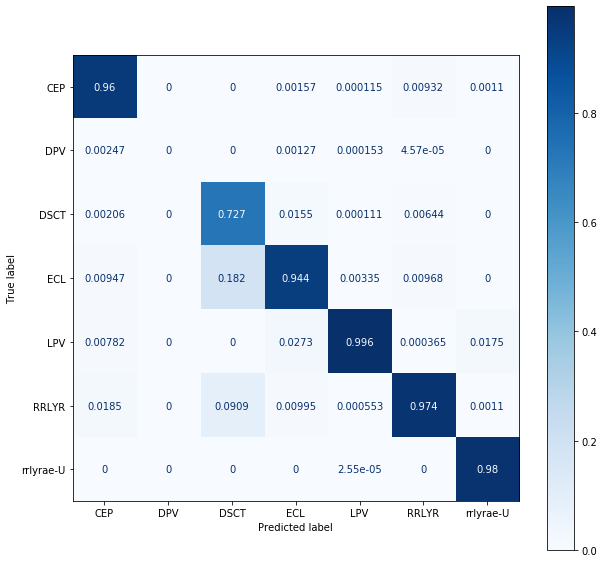

In [56]:
images, labels, probs = get_predictions(model, train_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

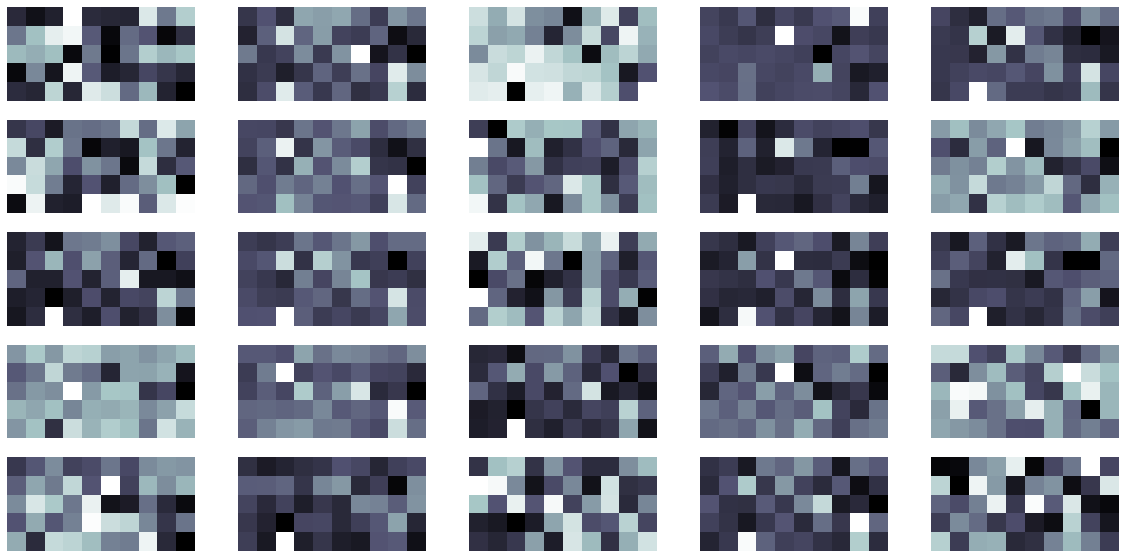

In [57]:
N_WEIGHTS = 25
weights = model.hidden_fc.weight.data
plot_weights(weights, N_WEIGHTS)